# UNet tutorial

## Import relevant packages

In [1]:
import torch
import torch.nn as nn
from torchsummary import summary

## Define double conv function

In [2]:
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3),
        nn.ReLU(inplace=True)
    )
    return conv

## Define crop tensor function

In [3]:
def crop_tensor(in_tensor, out_tensor):
    out_size = out_tensor.size()[2]
    in_size = in_tensor.size()[2]
    
    if in_size%2 == 1:
        in_size -= 1
    
    diff = in_size - out_size
    delta = diff // 2
    return in_tensor[:, :, delta:in_size-delta, delta:in_size-delta]

## UNet architecture

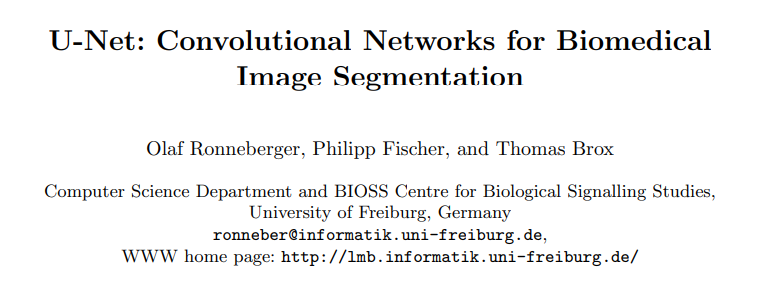

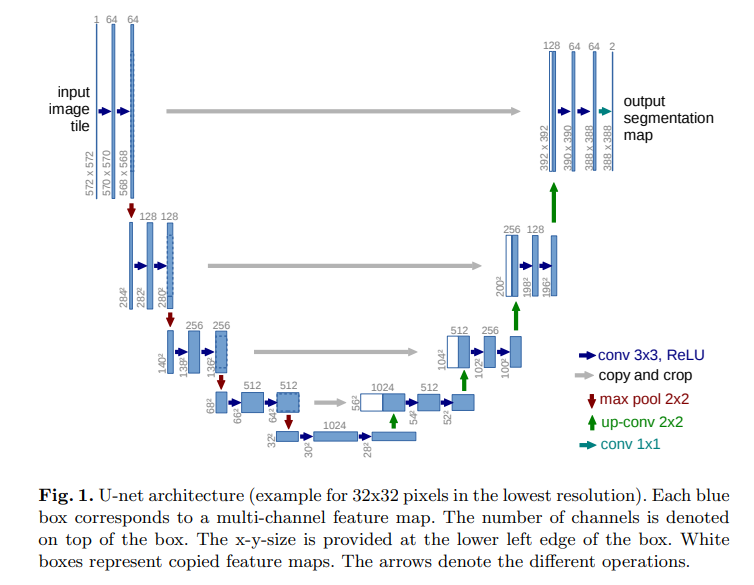

## Define UNet class

In [4]:
class UNet(nn.Module):
    def __init__(self, num_down_conv_layers = 5, num_up_conv_layers = 4):
        super(UNet, self).__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        channels = [1]
        channels += [2**(k+6) for k in range(num_down_conv_layers)]
        
        self.num_down_conv_layers = num_down_conv_layers
        self.down_conv_layers_idx = [i+1 for i in range(num_down_conv_layers)]
        self.down_conv_layers = nn.ModuleList(
            [double_conv(channels[j], channels[j+1]) for j in range(self.num_down_conv_layers)]
        )
        
        self.num_up_conv_layers = num_up_conv_layers
        self.up_trans_layers = nn.ModuleList(
            [nn.ConvTranspose2d(in_channels = channels[-(j+1)],
                               out_channels = channels[-(j+2)],
                               kernel_size = 2,
                               stride = 2)
             for j in range(self.num_up_conv_layers)]
        )
        self.up_conv_layers = nn.ModuleList(
            [double_conv(channels[-(j+1)], channels[-(j+2)]) for j in range(self.num_up_conv_layers)]
        )
        
        self.out = nn.Conv2d(
            in_channels = channels[1],
            out_channels = 2,
            kernel_size = 1
        )
    
    def forward(self, input_image):
        # encoder
        encoder_output_list = []
        x = input_image
        for down_layer_iter, down_conv_layer in enumerate(self.down_conv_layers):
            x = down_conv_layer(x)
            if self.down_conv_layers_idx[down_layer_iter] < self.num_down_conv_layers:
                encoder_output_list.append(x)
                x = self.max_pool_2x2(x)
        encoder_output_final = x
        
        # decoder
        for up_layer_iter in range(self.num_up_conv_layers):
            up_trans_layer = self.up_trans_layers[up_layer_iter]
            up_conv_layer = self.up_conv_layers[up_layer_iter]
            x = up_trans_layer(x)
            y = crop_tensor(encoder_output_list[-(up_layer_iter + 1)], x)
            x = up_conv_layer(torch.cat([x, y], 1))
        decoder_output_final = x
        
        # segmentation mask
        output = self.out(decoder_output_final)
        
        return output

## Model summary

In [5]:
summary_model = UNet()

In [6]:
summary_image = torch.rand((1, 1, 572, 572))
_, summary_num_channels, summary_height, summary_width = summary_image.size()

In [7]:
summary(summary_model, input_size = (summary_num_channels, summary_height, summary_width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 570, 570]             640
              ReLU-2         [-1, 64, 570, 570]               0
            Conv2d-3         [-1, 64, 568, 568]          36,928
              ReLU-4         [-1, 64, 568, 568]               0
         MaxPool2d-5         [-1, 64, 284, 284]               0
            Conv2d-6        [-1, 128, 282, 282]          73,856
              ReLU-7        [-1, 128, 282, 282]               0
            Conv2d-8        [-1, 128, 280, 280]         147,584
              ReLU-9        [-1, 128, 280, 280]               0
        MaxPool2d-10        [-1, 128, 140, 140]               0
           Conv2d-11        [-1, 256, 138, 138]         295,168
             ReLU-12        [-1, 256, 138, 138]               0
           Conv2d-13        [-1, 256, 136, 136]         590,080
             ReLU-14        [-1, 256, 1